In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pygmt
from obspy.core import UTCDateTime

In [3]:
# Read in features, look at names & datatypes
df_original = pd.read_csv('../P_station_analysis/p_features.csv', dtype={'location_code': str})
print(len(df_original))
print(df_original.dtypes)

72952
arrival_identifier                int64
avg_noise_1.00                  float64
avg_noise_10.00                 float64
avg_noise_11.00                 float64
avg_noise_12.00                 float64
avg_noise_13.00                 float64
avg_noise_14.00                 float64
avg_noise_15.00                 float64
avg_noise_16.00                 float64
avg_noise_17.00                 float64
avg_noise_18.00                 float64
avg_noise_2.00                  float64
avg_noise_3.00                  float64
avg_noise_4.00                  float64
avg_noise_5.00                  float64
avg_noise_6.00                  float64
avg_noise_7.00                  float64
avg_noise_8.00                  float64
avg_noise_9.00                  float64
avg_signal_1.00                 float64
avg_signal_10.00                float64
avg_signal_11.00                float64
avg_signal_12.00                float64
avg_signal_13.00                float64
avg_signal_14.00                fl

In [4]:
# Get metadata for 1 and 3c stations
eq_meta_onec = pd.read_csv("../currentEarthquakeArrivalInformation1CWithGains.csv")
eq_meta_threec = pd.read_csv("../currentEarthquakeArrivalInformation3CWithGains.csv")
eq_meta_all = pd.concat([eq_meta_onec, eq_meta_threec])

# Reduce to just location information
all_eq_locs = eq_meta_all.drop_duplicates("evid")[["evid", "event_lat", "event_lon", "origin_time"]]
all_eq_locs.columns = ["event_identifier", "event_lat", "event_lon", "origin_time"]

# Reduce to events in the dataset 
eq_locs_df = all_eq_locs[np.isin(all_eq_locs.event_identifier, df_original.event_identifier.unique())]
# Make date column for filtering
eq_locs_df.loc[:, "date"] = eq_locs_df.origin_time.apply(lambda x: int(UTCDateTime(x).strftime("%y%m%d")))

/tmp/ipykernel_28702/187499698.py:3: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  eq_meta_threec = pd.read_csv("../currentEarthquakeArrivalInformation3CWithGains.csv")
/tmp/ipykernel_28702/187499698.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eq_locs_df.loc[:, "date"] = eq_locs_df.origin_time.apply(lambda x: int(UTCDateTime(x).strftime("%y%m%d")))


In [5]:
# Set filter bounds
lat_min = 44.680
lat_max = 44.870
lon_max = 110.850
lon_min = 110.640
date_min = 130901  # YYMMDD
date_max = 140630  # YYMMDD
bounds = {"lat_min": lat_min,
          "lat_max": lat_max,
          "lon_max": lon_max,
          "lon_min": lon_min,
          "date_min": date_min,
          "date_max": date_max}

# Get ngb event ids
ngb_event_locs = eq_locs_df.loc[
        (eq_locs_df["date"] >= bounds["date_min"]) & (eq_locs_df["date"] <= bounds["date_max"]) & (eq_locs_df["event_lat"] >= bounds["lat_min"])
        & (eq_locs_df["event_lat"] <= bounds["lat_max"]) & (-1 * eq_locs_df["event_lon"] >= bounds["lon_min"]) & (
                    -1 * eq_locs_df["event_lon"] <= bounds["lon_max"])]

In [6]:
df_ngb_removed = df_original[~np.isin(df_original.event_identifier, ngb_event_locs.event_identifier)]
df_ngb = df_original[np.isin(df_original.event_identifier, ngb_event_locs.event_identifier)]
np.where(np.isin(df_ngb_removed.event_identifier, df_ngb.event_identifier))

(array([], dtype=int64),)

In [7]:
# Read in park and caldera boundaries
utahnet_path = "../../maps/utahnet"
ys_border = pd.read_csv(f"{utahnet_path}/yell.border.g", delimiter=" ", names=["Longitude", "Latitude"], dtype=np.float64)
caldera = pd.read_csv(f"{utahnet_path}/caldera.ys", sep="\s+", names=["Latitude", "Longitude"], dtype=np.float64)

caldera = caldera.drop(caldera[caldera["Longitude"]==0].index)
caldera = caldera[["Longitude", "Latitude"]]
caldera["Longitude"] = caldera["Longitude"]*-1

In [8]:
# Lat/lon bounding box I could use to scale the source locations
bb_lat_min = ys_border.Latitude.min() - 0.2
bb_lat_max = ys_border.Latitude.max()
bb_lon_min = ys_border.Longitude.min() - 0.15
bb_lon_max = ys_border.Longitude.max()
ys_bb = [[bb_lon_max, bb_lat_max], [bb_lon_max, bb_lat_min], [bb_lon_min, bb_lat_min], [bb_lon_min, bb_lat_max], [bb_lon_max, bb_lat_max]]

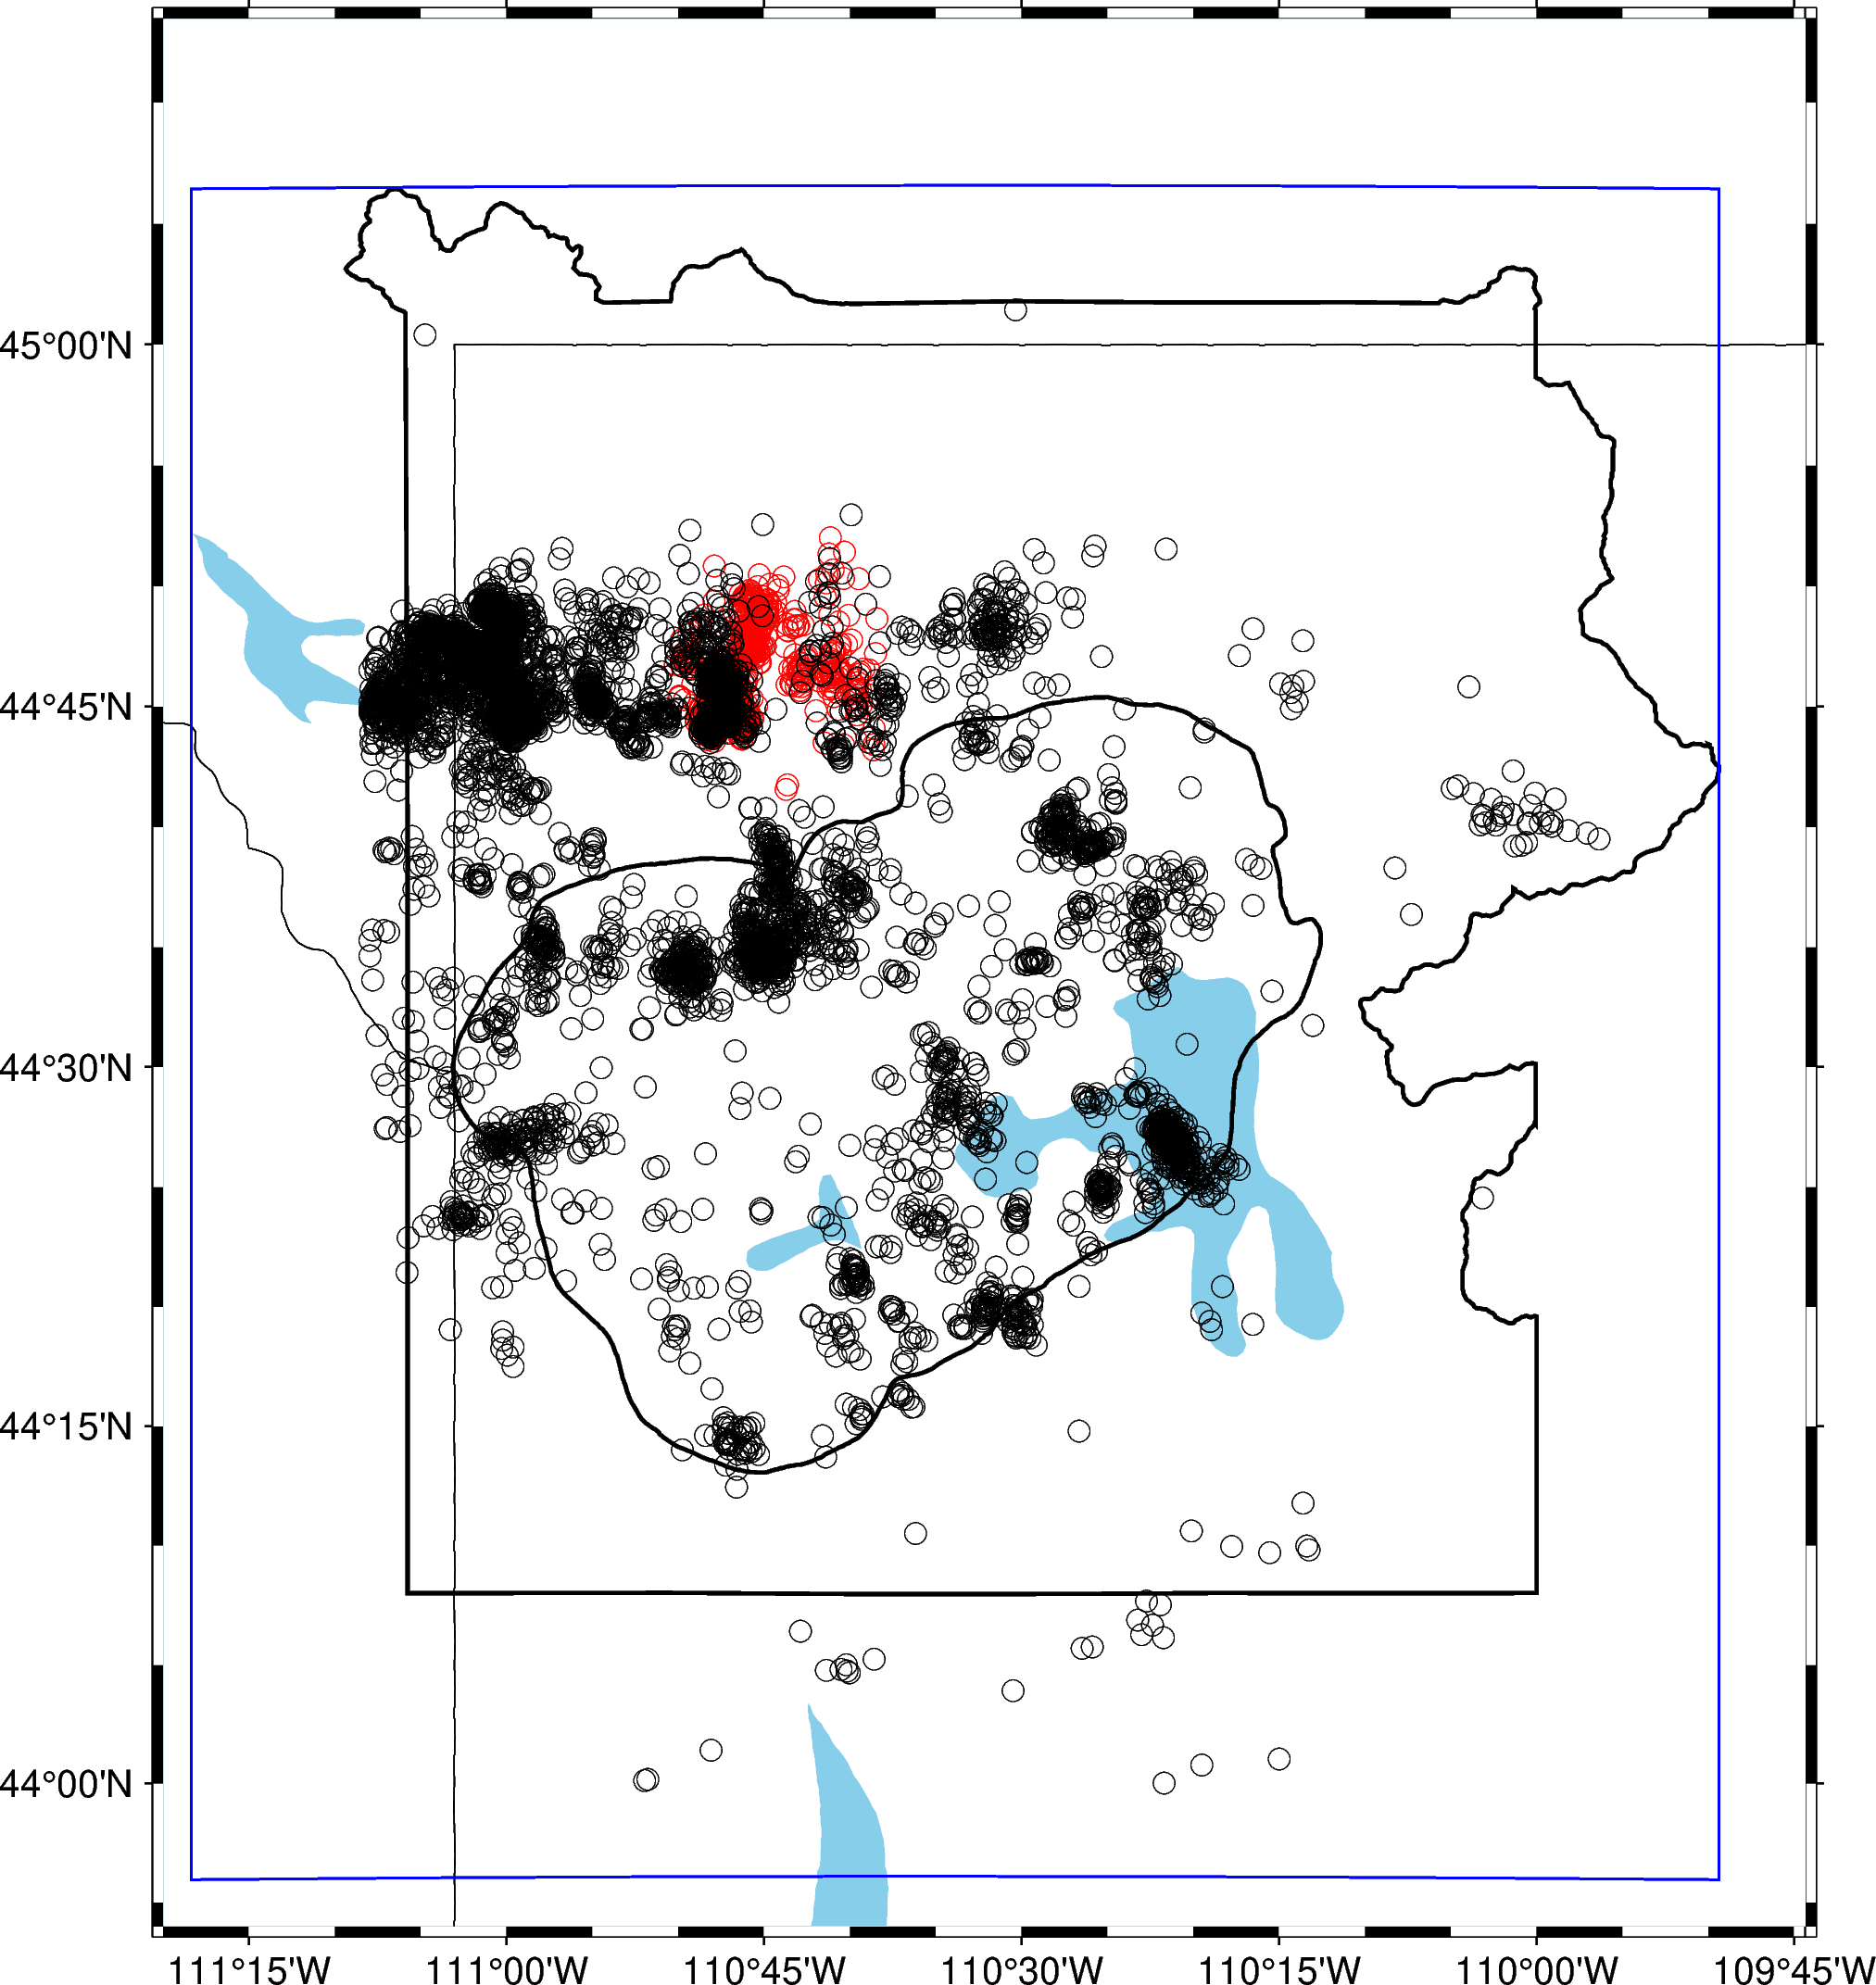

In [9]:
#Draw event map 
region = [
    eq_locs_df.event_lon.min() - 0.2,
    eq_locs_df.event_lon.max() + 0.2,
    eq_locs_df.event_lat.min() - 0.1,
    eq_locs_df.event_lat.max() + 0.2,
]

unique_locations = df_ngb_removed[["source_longitude", "source_latitude"]].drop_duplicates()
unique_ngb_locations = df_ngb[["source_longitude", "source_latitude"]].drop_duplicates()

fig = pygmt.Figure()
fig.basemap(region=region, projection="M15c", frame=True)
fig.coast(land="white", borders=2, water="skyblue")
fig.plot(data=ys_border, pen="1.0p,black")
fig.plot(data=caldera, pen='1.0p,black')
fig.plot(x=unique_ngb_locations.source_longitude, y=unique_ngb_locations.source_latitude, style="c0.2c", pen="0.2p,red")
fig.plot(x=unique_locations.source_longitude, y=unique_locations.source_latitude, style="c0.2c", pen="0.2p,black")
fig.plot(ys_bb, pen="0.6p,blue")
fig.show()

In [10]:
# Keep stations with more than 350 observations
stat_counts = df_original.value_counts("station").to_frame().reset_index()
stat_counts.columns = ["Station", "Count"]
df_org_filtcounts = df_ngb_removed[np.isin(df_ngb_removed.station, stat_counts[stat_counts.Count >= 350])]

In [11]:
stat_counts

,Station,Count
0,YNR,5017
1,YHH,5007
2,YMC,4451
3,YMR,4238
4,YPM,4201
5,YWB,3855
6,MCID,3714
7,YHB,3654
8,YFT,3638
9,YHL,3421


## Feature selection?

In [12]:
# Make train and test datasets

test_size = 0.2
station = "YNR"

station_df = df_org_filtcounts[df_org_filtcounts.station == station]

evids = np.unique(station_df.event_identifier)
train_evids, test_evids = train_test_split(evids, test_size = test_size, random_state = 843823)

train_inds = np.isin(station_df.event_identifier, train_evids)
train_df = station_df[train_inds]
test_df = station_df[~train_inds]

assert len(train_df.event_identifier.unique()) == len(train_evids)
assert len(test_df.event_identifier.unique()) == len(test_evids)
assert len(test_df) + len(train_df) == len(station_df)

In [13]:
df_org_filtcounts.source_receiver_back_azimuth

0         79.885217
1         62.981132
2          3.296971
3          6.698827
4        305.555989
            ...    
72947    231.711248
72948    290.611070
72949    158.351616
72950    323.261510
72951    287.141359
Name: source_receiver_back_azimuth, Length: 61716, dtype: float64

In [14]:
?np.sin

In [15]:
# Computes the feature matrix from a dataframe
# Computes the feature matrix from a dataframe
def compute_feature_matrix(df, scaler = True):
    # Loosely speaking empirical magnitudes look like:
    # M = log10(A) + Q(Delta) 
    # where A is the amplitude and Q a distance dependent correction term.
    # Additionally, the difference between log10 and log amounts to a scalar
    # that a machine can learn.
    # Basically, I'm interested in features that:
    #   (1) Measure size in, potentially, different amplitudes.
    # different `passbands' deviates from the noise, 
    n_rows = len(df)
    n_columns = 46
    X = np.zeros([n_rows, n_columns])
    # Get a proxy on size
    
    # These are effectively amplitude ratios.  Note,
    # log(a/b) = log(a) - log(b)
    X[:,0]  = np.log(df['avg_signal_1.00']) - np.log(df['avg_noise_1.00'])
    X[:,1]  = np.log(df['avg_signal_2.00']) - np.log(df['avg_noise_2.00'])
    X[:,2]  = np.log(df['avg_signal_3.00']) - np.log(df['avg_noise_3.00'])
    X[:,3]  = np.log(df['avg_signal_4.00']) - np.log(df['avg_noise_4.00'])
    X[:,4]  = np.log(df['avg_signal_5.00']) - np.log(df['avg_noise_5.00'])
    X[:,5]  = np.log(df['avg_signal_6.00']) - np.log(df['avg_noise_6.00'])
    X[:,6]  = np.log(df['avg_signal_7.00']) - np.log(df['avg_noise_7.00'])
    X[:,7]  = np.log(df['avg_signal_8.00']) - np.log(df['avg_noise_8.00'])
    X[:,8]  = np.log(df['avg_signal_9.00']) - np.log(df['avg_noise_9.00'])
    X[:,9]  = np.log(df['avg_signal_10.00']) - np.log(df['avg_noise_10.00'])
    X[:,10] = np.log(df['avg_signal_11.00']) - np.log(df['avg_noise_11.00'])
    X[:,11] = np.log(df['avg_signal_12.00']) - np.log(df['avg_noise_12.00'])
    X[:,12] = np.log(df['avg_signal_13.00']) - np.log(df['avg_noise_13.00'])
    X[:,13] = np.log(df['avg_signal_14.00']) - np.log(df['avg_noise_14.00'])
    X[:,14] = np.log(df['avg_signal_15.00']) - np.log(df['avg_noise_15.00'])
    X[:,15] = np.log(df['avg_signal_16.00']) - np.log(df['avg_noise_16.00'])
    X[:,16] = np.log(df['avg_signal_17.00']) - np.log(df['avg_noise_17.00'])
    X[:,17] = np.log(df['avg_signal_18.00']) - np.log(df['avg_noise_18.00'])
    # Look at amplitudes
    X[:,18] = np.log(df['avg_signal_1.00']) 
    X[:,19] = np.log(df['avg_signal_2.00']) 
    X[:,20] = np.log(df['avg_signal_3.00']) 
    X[:,21] = np.log(df['avg_signal_4.00']) 
    X[:,22] = np.log(df['avg_signal_5.00'])
    X[:,23] = np.log(df['avg_signal_6.00'])
    X[:,24] = np.log(df['avg_signal_7.00'])
    X[:,25] = np.log(df['avg_signal_8.00'])
    X[:,26] = np.log(df['avg_signal_9.00'])
    X[:,27] = np.log(df['avg_signal_10.00'])
    X[:,28] = np.log(df['avg_signal_11.00'])
    X[:,29] = np.log(df['avg_signal_12.00'])
    X[:,30] = np.log(df['avg_signal_13.00'])
    X[:,31] = np.log(df['avg_signal_14.00'])
    X[:,32] = np.log(df['avg_signal_15.00'])
    X[:,33] = np.log(df['avg_signal_16.00'])
    X[:,34] = np.log(df['avg_signal_17.00'])
    X[:,35] = np.log(df['avg_signal_18.00'])
    # Frequency and max amplitude
    X[:,36] = np.log(df['signal_dominant_frequency'])
    X[:,37] = np.log(df['signal_dominant_amplitude'])
    # Time-based featuers: Look at max amplitudes of noise/signal
    X[:,38] = np.log(df['noise_maximum_value']  - df['noise_minimum_value'])
    X[:,39] = np.log(df['signal_maximum_value'] - df['signal_minimum_value'])
    X[:,40] = np.log(df['signal_variance'])
    X[:,41] = np.log(df['noise_variance'])
    # Source/recv distance (take log to flatten this)
    X[:,42] = np.log(df['source_receiver_distance_km'])
    X[:,43] = df['source_depth_km']
    # Single stations can learn location
#     X[:,44] = df['source_latitude']
#     X[:,45] = df['source_longitude']
    X[:,44] = np.sin(df['source_receiver_back_azimuth']*np.pi/180)
    X[:,45] = df['source_receiver_back_azimuth']

    # Standardize features
    if (scaler):
        scaler = StandardScaler()
        scaler = scaler.fit(X)
        X = scaler.transform(X)
        return X, scaler
    
    return X

In [16]:
train_feat_matrix_scaled, scaler = compute_feature_matrix(train_df)
train_feat_matrix_unscaled = compute_feature_matrix(train_df, scaler=False)

train_y = train_df.magnitude.values

In [17]:
train_feat_matrix_scaled[0], train_feat_matrix_unscaled[0]

(array([ 1.81335314,  0.84960982,  1.43179994,  1.19563459,  0.52969987,
        -0.36461194, -0.68864504, -0.75263395, -0.75677581, -0.7195594 ,
        -0.69514561, -0.71428606, -0.71541888, -0.68451884, -0.64897372,
        -0.61732443, -0.59269037, -0.57998005,  2.80073673,  1.86032406,
         1.87643718,  1.54373157,  0.98449291,  0.502731  ,  0.30299436,
         0.24142232,  0.20269387,  0.16820796,  0.1096196 ,  0.02244586,
        -0.04938522, -0.07907677, -0.07793168, -0.06611791, -0.05312792,
        -0.04405737, -4.03307982,  0.81938864,  2.15928381,  0.45411585,
         0.74691447,  1.91323555,  1.53235692,  1.97599049, -0.09164738,
        -0.31082953]),
 array([  2.91911297,   2.4089576 ,   3.31309329,   3.42328096,
          3.02747131,   2.31886496,   2.1994042 ,   2.41542596,
          2.65745246,   2.87601498,   3.04400326,   3.1393346 ,
          3.22839125,   3.32875621,   3.4125859 ,   3.47531788,
          3.51756978,   3.53587076,  -0.42488365,  -1.00347039,


In [18]:
train_y

array([3.16, 2.5 , 2.  , ..., 1.93, 1.63, 1.79])

In [19]:
for col in df_org_filtcounts.columns:
    print(col)

arrival_identifier
avg_noise_1.00
avg_noise_10.00
avg_noise_11.00
avg_noise_12.00
avg_noise_13.00
avg_noise_14.00
avg_noise_15.00
avg_noise_16.00
avg_noise_17.00
avg_noise_18.00
avg_noise_2.00
avg_noise_3.00
avg_noise_4.00
avg_noise_5.00
avg_noise_6.00
avg_noise_7.00
avg_noise_8.00
avg_noise_9.00
avg_signal_1.00
avg_signal_10.00
avg_signal_11.00
avg_signal_12.00
avg_signal_13.00
avg_signal_14.00
avg_signal_15.00
avg_signal_16.00
avg_signal_17.00
avg_signal_18.00
avg_signal_2.00
avg_signal_3.00
avg_signal_4.00
avg_signal_5.00
avg_signal_6.00
avg_signal_7.00
avg_signal_8.00
avg_signal_9.00
channel
event_identifier
location_code
magnitude
magnitude_type
network
noise_dominant_amplitude
noise_dominant_frequency
noise_maximum_value
noise_minimum_value
noise_variance
signal_dominant_amplitude
signal_dominant_frequency
signal_maximum_value
signal_minimum_value
signal_variance
source_depth_km
source_latitude
source_longitude
source_receiver_back_azimuth
source_receiver_distance_km
station


In [20]:
columns=["amp_ratio_01.0", "amp_ratio_02.0", "amp_ratio_03.0", "amp_ratio_04.0", 
                                 "amp_ratio_05.0", "amp_ratio_06.0", "amp_ratio_07.0", "amp_ratio_08.0",
                                 "amp_ratio_09.0", "amp_ratio_10.0", "amp_ratio_11.0", "amp_ratio_12.0", 
                                 "amp_ratio_13.0", "amp_ratio_14.0", "amp_ratio_15.0", "amp_ratio_16.0", 
                                 "amp_ratio_17.0", "amp_ratio_18.0", 
                                 "amp_01.0", "amp_02.0", "amp_03.0", "amp_04.0", 
                                 "amp_05.0", "amp_06.0", "amp_07.0", "amp_08.0",
                                 "amp_09.0", "amp_10.0", "amp_11.0", "amp_12.0", 
                                 "amp_13.0", "amp_14.0", "amp_15.0", "amp_16.0", 
                                 "amp_17.0", "amp_18.0",
                                 "signal_dominant_frequency", "signal_dominant_amplitude", 
                                 "noise_max_amplitude", "signal_max_amplitude", "signal_variance", "noise_variance",
                                 "source_receiver_distance_logkm", "source_depth_km", 
                                 "sin_receiver_back_azimuth", "receiver_back_azimuth"]
train_feat_df = pd.DataFrame(train_feat_matrix_scaled, columns=columns)

In [21]:
train_feat_df_unscaled = pd.DataFrame(train_feat_matrix_unscaled, columns=columns)

In [22]:
feat_target_df = train_feat_df.copy()
feat_target_df.loc[:, "magnitude"] = train_y
corr = feat_target_df.corr()
corr.style.background_gradient(cmap="coolwarm")

,amp_ratio_01.0,amp_ratio_02.0,amp_ratio_03.0,amp_ratio_04.0,amp_ratio_05.0,amp_ratio_06.0,amp_ratio_07.0,amp_ratio_08.0,amp_ratio_09.0,amp_ratio_10.0,amp_ratio_11.0,amp_ratio_12.0,amp_ratio_13.0,amp_ratio_14.0,amp_ratio_15.0,amp_ratio_16.0,amp_ratio_17.0,amp_ratio_18.0,amp_01.0,amp_02.0,amp_03.0,amp_04.0,amp_05.0,amp_06.0,amp_07.0,amp_08.0,amp_09.0,amp_10.0,amp_11.0,amp_12.0,amp_13.0,amp_14.0,amp_15.0,amp_16.0,amp_17.0,amp_18.0,signal_dominant_frequency,signal_dominant_amplitude,noise_max_amplitude,signal_max_amplitude,signal_variance,noise_variance,source_receiver_distance_logkm,source_depth_km,sin_receiver_back_azimuth,receiver_back_azimuth,magnitude
amp_ratio_01.0,1.000000,0.750955,0.640405,0.571107,0.524419,0.504911,0.490370,0.464650,0.430359,0.397611,0.366040,0.335356,0.309645,0.291038,0.278453,0.269961,0.264081,0.259819,0.606635,0.591570,0.529418,0.498298,0.478968,0.474628,0.466972,0.450357,0.431149,0.414762,0.399630,0.384428,0.371436,0.362281,0.356369,0.352626,0.350298,0.348880,-0.236852,0.436935,-0.117124,0.425969,0.443622,-0.150531,-0.144718,-0.148294,0.227191,-0.189199,0.471477
amp_ratio_02.0,0.750955,1.000000,0.827265,0.728293,0.689953,0.681896,0.664930,0.626113,0.581367,0.545774,0.516288,0.487068,0.460570,0.440394,0.426408,0.417055,0.410815,0.406610,0.492882,0.708249,0.639335,0.597377,0.585725,0.595981,0.591647,0.570827,0.549597,0.535396,0.524733,0.512775,0.500936,0.491907,0.485980,0.482393,0.480421,0.479507,-0.156134,0.554720,-0.172155,0.551335,0.565055,-0.206028,-0.318465,-0.202315,0.248256,-0.208356,0.436740
amp_ratio_03.0,0.640405,0.827265,1.000000,0.896326,0.826339,0.807817,0.794579,0.767141,0.732172,0.703123,0.678227,0.651875,0.626631,0.606628,0.592212,0.582178,0.575182,0.570269,0.545740,0.735314,0.779484,0.736839,0.716854,0.723502,0.721990,0.707729,0.691740,0.680609,0.672183,0.662255,0.651872,0.643683,0.638078,0.634496,0.632375,0.631239,-0.079379,0.689257,-0.093037,0.690961,0.703827,-0.113991,-0.404264,-0.188833,0.176228,-0.123922,0.486986
amp_ratio_04.0,0.571107,0.728293,0.896326,1.000000,0.950290,0.902268,0.876488,0.849473,0.817849,0.792207,0.771255,0.748617,0.726337,0.708214,0.694853,0.685346,0.678606,0.673743,0.599018,0.771431,0.815352,0.829888,0.818567,0.812451,0.804593,0.790170,0.774596,0.763770,0.756105,0.747353,0.738001,0.730264,0.724686,0.720916,0.718517,0.717083,-0.062456,0.776851,-0.038990,0.777288,0.787354,-0.052329,-0.429643,-0.187262,0.208611,-0.154128,0.557284
amp_ratio_05.0,0.524419,0.689953,0.826339,0.950290,1.000000,0.973015,0.937459,0.903732,0.869519,0.842949,0.821712,0.799102,0.777025,0.758990,0.745658,0.736166,0.729442,0.724605,0.615591,0.788360,0.821167,0.844191,0.860628,0.859971,0.849162,0.832733,0.816485,0.805732,0.798427,0.790110,0.781141,0.773649,0.768189,0.764455,0.762048,0.760593,-0.035861,0.816182,-0.010089,0.817299,0.825510,-0.018315,-0.455878,-0.181512,0.229852,-0.185638,0.569009
amp_ratio_06.0,0.504911,0.681896,0.807817,0.902268,0.973015,1.000000,0.983012,0.945751,0.906511,0.877118,0.853928,0.829491,0.805716,0.786340,0.772125,0.762099,0.755071,0.750099,0.610548,0.792917,0.821776,0.837256,0.860860,0.879222,0.876142,0.858860,0.841562,0.830771,0.823736,0.815431,0.806180,0.798395,0.792740,0.788914,0.786484,0.785050,-0.009480,0.833265,0.003581,0.836475,0.843221,-0.002276,-0.490444,-0.171114,0.206241,-0.178382,0.548337
amp_ratio_07.0,0.490370,0.664930,0.794579,0.876488,0.937459,0.983012,1.000000,0.983085,0.950038,0.920831,0.896103,0.870127,0.845092,0.824727,0.809779,0.799206,0.791757,0.786450,0.607808,0.791935,0.822721,0.834906,0.856623,0.881390,0.891070,0.883149,0.869882,0.860165,0.853081,0.844687,0.835512,0.827857,0.822290,0.818474,0.815983,0.814437,0.028217,0.851057,0.008711,0.856041,0.862768,0.006176,-0.494698,-0.155404,0.173570,-0.152207,0.553107
amp_ratio_08.0,0.464650,0.626113,0.767141,0.849473,0.903732,0.945751,0.983085,1.000000,0.988501,0.967180,0.943684,0.917270,0.891790,0.871028,0.855679,0.844681,0.836790,0.831027,0.600723,0.781064,0.819232,0.832573,0.852303,0.873721,0.8

In [23]:
from sklearn.feature_selection import mutual_info_regression, SequentialFeatureSelector, RFE

In [24]:
mutual_reg = mutual_info_regression(train_feat_matrix_scaled, train_y, random_state=843824)
mutual_reg

array([0.12669423, 0.13141387, 0.15899074, 0.20372684, 0.20801849,
       0.19889779, 0.19887474, 0.23066899, 0.2457443 , 0.22621924,
       0.2384843 , 0.22392051, 0.17939958, 0.19945414, 0.16681981,
       0.16391402, 0.16043663, 0.17158668, 0.33168171, 0.34808179,
       0.34532651, 0.33810255, 0.31334632, 0.31938171, 0.29578653,
       0.31495363, 0.32983095, 0.31273781, 0.31162603, 0.2946676 ,
       0.2847925 , 0.28062185, 0.2785755 , 0.27318071, 0.26720103,
       0.27592274, 0.06206527, 0.27031238, 0.04468285, 0.28129486,
       0.30369445, 0.03973831, 0.09379877, 0.02289251, 0.08587664,
       0.13043172])

In [25]:
train_feat_df.columns[np.argsort(mutual_reg, axis=0)]

Index(['source_depth_km', 'noise_variance', 'noise_max_amplitude',
       'signal_dominant_frequency', 'sin_receiver_back_azimuth',
       'source_receiver_distance_logkm', 'amp_ratio_01.0',
       'receiver_back_azimuth', 'amp_ratio_02.0', 'amp_ratio_03.0',
       'amp_ratio_17.0', 'amp_ratio_16.0', 'amp_ratio_15.0', 'amp_ratio_18.0',
       'amp_ratio_13.0', 'amp_ratio_07.0', 'amp_ratio_06.0', 'amp_ratio_14.0',
       'amp_ratio_04.0', 'amp_ratio_05.0', 'amp_ratio_12.0', 'amp_ratio_10.0',
       'amp_ratio_08.0', 'amp_ratio_11.0', 'amp_ratio_09.0', 'amp_17.0',
       'signal_dominant_amplitude', 'amp_16.0', 'amp_18.0', 'amp_15.0',
       'amp_14.0', 'signal_max_amplitude', 'amp_13.0', 'amp_12.0', 'amp_07.0',
       'signal_variance', 'amp_11.0', 'amp_10.0', 'amp_05.0', 'amp_08.0',
       'amp_06.0', 'amp_09.0', 'amp_01.0', 'amp_04.0', 'amp_03.0', 'amp_02.0'],
      dtype='object')

In [26]:
# Make cross validation splits across evids

from sklearn.model_selection import KFold
evids = train_df.event_identifier.unique()
kf = KFold(n_splits=5, shuffle=True, random_state=843824)
folds = []
for train_index, test_index in kf.split(evids):
    # Get the evids corresponding to the split indicies
    fold_train_evids = evids[train_index]
    fold_test_evids = evids[test_index]
    # Get rows of training dataset that correspond to split evids
    fold_train_inds = np.where(np.isin(train_df.event_identifier, fold_train_evids))[0]
    fold_test_inds = np.where(np.isin(train_df.event_identifier, fold_test_evids))[0]
    
    folds.append((fold_train_inds, fold_test_inds))

In [27]:
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_validate
from sklearn.metrics import r2_score

## RFE

from RFECV, know that most of the gain comes from 5-10 features. Use RFE to find 8 "best" features

In [28]:
# CV performace with these all features in linear model
svr = SVR(C=1.0, epsilon=0.1, kernel="linear")
pipeline = Pipeline(steps=[("scaler", StandardScaler()), ('svr', svr)])
cross_validate(pipeline, train_feat_matrix_unscaled[:, :-1], train_y, cv=folds, scoring="r2")

{'fit_time': array([2.54701853, 2.64878798, 2.59306407, 2.43593454, 2.37047529]),
 'score_time': array([0.04216576, 0.04289556, 0.04962826, 0.04510093, 0.04851675]),
 'test_score': array([0.70485198, 0.75671302, 0.80963424, 0.80561731, 0.7913357 ])}

In [29]:
train_feat_df.columns[:-1]

Index(['amp_ratio_01.0', 'amp_ratio_02.0', 'amp_ratio_03.0', 'amp_ratio_04.0',
       'amp_ratio_05.0', 'amp_ratio_06.0', 'amp_ratio_07.0', 'amp_ratio_08.0',
       'amp_ratio_09.0', 'amp_ratio_10.0', 'amp_ratio_11.0', 'amp_ratio_12.0',
       'amp_ratio_13.0', 'amp_ratio_14.0', 'amp_ratio_15.0', 'amp_ratio_16.0',
       'amp_ratio_17.0', 'amp_ratio_18.0', 'amp_01.0', 'amp_02.0', 'amp_03.0',
       'amp_04.0', 'amp_05.0', 'amp_06.0', 'amp_07.0', 'amp_08.0', 'amp_09.0',
       'amp_10.0', 'amp_11.0', 'amp_12.0', 'amp_13.0', 'amp_14.0', 'amp_15.0',
       'amp_16.0', 'amp_17.0', 'amp_18.0', 'signal_dominant_frequency',
       'signal_dominant_amplitude', 'noise_max_amplitude',
       'signal_max_amplitude', 'signal_variance', 'noise_variance',
       'source_receiver_distance_logkm', 'source_depth_km',
       'sin_receiver_back_azimuth'],
      dtype='object')

In [30]:
# Find best features for whole training dataset
estimator = SVR(kernel="linear")
selector = RFE(estimator, n_features_to_select=8, step=1)
selector = selector.fit(train_feat_matrix_scaled[:, :-1], train_y)

train_feat_df.columns[:-1][selector.support_]

Index(['amp_ratio_10.0', 'amp_ratio_11.0', 'amp_09.0', 'amp_10.0', 'amp_18.0',
       'signal_max_amplitude', 'signal_variance',
       'source_receiver_distance_logkm'],
      dtype='object')

In [31]:
# Sort features by importance - first 8 are in no particular order
train_feat_df.columns[:-1][np.argsort(selector.ranking_)]

Index(['amp_09.0', 'source_receiver_distance_logkm', 'signal_variance',
       'signal_max_amplitude', 'amp_10.0', 'amp_18.0', 'amp_ratio_10.0',
       'amp_ratio_11.0', 'amp_15.0', 'amp_ratio_13.0', 'amp_ratio_12.0',
       'sin_receiver_back_azimuth', 'signal_dominant_amplitude', 'amp_02.0',
       'amp_14.0', 'amp_17.0', 'amp_03.0', 'amp_04.0', 'amp_ratio_15.0',
       'amp_ratio_18.0', 'amp_ratio_17.0', 'amp_01.0', 'amp_13.0', 'amp_11.0',
       'amp_ratio_14.0', 'amp_ratio_04.0', 'amp_16.0', 'amp_05.0', 'amp_06.0',
       'amp_07.0', 'noise_variance', 'amp_ratio_09.0', 'amp_ratio_06.0',
       'amp_ratio_16.0', 'amp_12.0', 'amp_ratio_07.0', 'amp_ratio_02.0',
       'amp_08.0', 'amp_ratio_08.0', 'source_depth_km', 'amp_ratio_05.0',
       'noise_max_amplitude', 'amp_ratio_01.0', 'amp_ratio_03.0',
       'signal_dominant_frequency'],
      dtype='object')

In [32]:
# Training performace with these 8 features in the linear model 
r2_score(selector.predict(train_feat_matrix_scaled[:, :-1]), train_y)

0.7029360869872143

In [33]:
# CV performace with these 8 features in non-linear model
svr = SVR(C=1.0, epsilon=0.2)
pipeline = Pipeline(steps=[("scaler", StandardScaler()), ('svr', svr)])
cross_validate(pipeline, train_feat_matrix_unscaled[:, :-1][:, selector.support_], train_y, cv=folds, scoring="r2")

{'fit_time': array([0.13329005, 0.1241765 , 0.12352896, 0.12028837, 0.12367892]),
 'score_time': array([0.02564573, 0.02615213, 0.02587056, 0.02528381, 0.02553391]),
 'test_score': array([0.80351101, 0.81529642, 0.78831106, 0.79260806, 0.80796791])}

In [34]:
# Get best RFE features for various folds and evaluate 
for fold in folds:
    # Pipeline for choosing features for fold
    estimator = SVR(kernel="linear")
    selector = RFE(estimator, n_features_to_select=8, step=1)
    pipeline = Pipeline(steps=[("scaler", StandardScaler()), ('selector', selector)])
    
    # Fold data - exclude receiver_back_azimuth since linear model
    cv_train_X = train_feat_matrix_unscaled[fold[0], :-1]
    cv_train_y = train_y[fold[0]]
    cv_test_X = train_feat_matrix_unscaled[fold[1], :-1]
    cv_test_y = train_y[fold[1]]
    
    # Fit selector to fold training data
    s = pipeline.fit(cv_train_X, cv_train_y)
    # Make predictions on the fold test data
    preds = s.predict(cv_test_X)
    # Get the features for this model
    support = s.named_steps.selector.support_
    # Print the features
    print(train_feat_df.columns[:-1][support])
    # Print the test R^2 score
    print("Linear performance:", r2_score(cv_test_y, preds))
    
    # Use this features in a non-linear model. Cross validate over all the folds
    svr = SVR(C=1.0, epsilon=0.2)
    nl_pipeline = Pipeline(steps=[("scaler", StandardScaler()), ('svr', svr)])
    rbf_cv = cross_validate(nl_pipeline, train_feat_matrix_unscaled[:, :-1][:, support],
                         train_y, cv=folds, scoring="r2")["test_score"]
    print(rbf_cv)
    print(np.mean(rbf_cv))

Index(['amp_09.0', 'amp_10.0', 'amp_15.0', 'amp_17.0', 'amp_18.0',
       'signal_max_amplitude', 'signal_variance',
       'source_receiver_distance_logkm'],
      dtype='object')
Linear performance: 0.6736242890432627
[0.80941372 0.81586824 0.78138379 0.79385452 0.81017121]
0.8021382969437699
Index(['amp_ratio_11.0', 'amp_09.0', 'amp_10.0', 'amp_13.0', 'amp_18.0',
       'signal_max_amplitude', 'signal_variance',
       'source_receiver_distance_logkm'],
      dtype='object')
Linear performance: 0.7290048069283646
[0.80356059 0.81517722 0.78342262 0.79292994 0.8083054 ]
0.8006791571462075
Index(['amp_02.0', 'amp_03.0', 'amp_04.0', 'amp_18.0',
       'signal_dominant_amplitude', 'signal_max_amplitude', 'signal_variance',
       'source_receiver_distance_logkm'],
      dtype='object')
Linear performance: 0.7782485619116034
[0.82298208 0.83263771 0.80209829 0.81269757 0.83005827]
0.8200947831391575
Index(['amp_06.0', 'amp_07.0', 'amp_08.0', 'amp_10.0', 'amp_17.0',
       'signal_max_amp

## Sequential Feature Selection. 
Forward selection until change in score is less than 1e-4 or reach half of the features. Slightly better CV performace with 13 features than 46 for non-linear SVR. Pretty comparable performace between the 13 and 46 features in linear SVR. 

In [35]:
no_sin_ba_feat_inds = np.delete(np.arange(train_feat_matrix_unscaled.shape[1]), -2)

In [36]:
train_feat_df.columns[no_sin_ba_feat_inds]

Index(['amp_ratio_01.0', 'amp_ratio_02.0', 'amp_ratio_03.0', 'amp_ratio_04.0',
       'amp_ratio_05.0', 'amp_ratio_06.0', 'amp_ratio_07.0', 'amp_ratio_08.0',
       'amp_ratio_09.0', 'amp_ratio_10.0', 'amp_ratio_11.0', 'amp_ratio_12.0',
       'amp_ratio_13.0', 'amp_ratio_14.0', 'amp_ratio_15.0', 'amp_ratio_16.0',
       'amp_ratio_17.0', 'amp_ratio_18.0', 'amp_01.0', 'amp_02.0', 'amp_03.0',
       'amp_04.0', 'amp_05.0', 'amp_06.0', 'amp_07.0', 'amp_08.0', 'amp_09.0',
       'amp_10.0', 'amp_11.0', 'amp_12.0', 'amp_13.0', 'amp_14.0', 'amp_15.0',
       'amp_16.0', 'amp_17.0', 'amp_18.0', 'signal_dominant_frequency',
       'signal_dominant_amplitude', 'noise_max_amplitude',
       'signal_max_amplitude', 'signal_variance', 'noise_variance',
       'source_receiver_distance_logkm', 'source_depth_km',
       'receiver_back_azimuth'],
      dtype='object')

In [37]:
svr = SVR(C=1.0, epsilon=0.2)
pipeline = Pipeline(steps=[("scaler", StandardScaler()), ('svr', svr)])
sfs = SequentialFeatureSelector(pipeline, n_features_to_select="auto", tol=1e-3, scoring="r2", 
                                cv=folds, n_jobs=3).fit(train_feat_matrix_unscaled[:,no_sin_ba_feat_inds], train_y)

sfs.get_feature_names_out(train_feat_df.columns[no_sin_ba_feat_inds])

array(['amp_ratio_02.0', 'amp_01.0', 'amp_11.0', 'signal_max_amplitude',
       'signal_variance', 'source_receiver_distance_logkm',
       'receiver_back_azimuth'], dtype=object)

In [38]:
svr = SVR(C=1.0, epsilon=0.2)
pipeline = Pipeline(steps=[("scaler", StandardScaler()), ('svr', svr)])
cross_validate(pipeline, train_feat_matrix_unscaled[:,no_sin_ba_feat_inds][:, sfs.get_support()], train_y, cv=folds)

{'fit_time': array([0.1231153 , 0.10657668, 0.10714984, 0.10952282, 0.1053915 ]),
 'score_time': array([0.02135515, 0.01939321, 0.01964688, 0.02050948, 0.02005386]),
 'test_score': array([0.86084682, 0.8705785 , 0.85704373, 0.85962512, 0.86450917])}

In [39]:
svr = SVR(C=1.0, epsilon=0.2)
pipeline = Pipeline(steps=[("scaler", StandardScaler()), ('svr', svr)])
sfs = SequentialFeatureSelector(pipeline, n_features_to_select="auto", tol=1e-4, scoring="r2", 
                                cv=folds, n_jobs=3).fit(train_feat_matrix_unscaled[:,no_sin_ba_feat_inds], train_y)

sfs.get_feature_names_out(train_feat_df.columns[no_sin_ba_feat_inds])

array(['amp_ratio_01.0', 'amp_ratio_02.0', 'amp_ratio_04.0', 'amp_01.0',
       'amp_02.0', 'amp_04.0', 'amp_08.0', 'amp_11.0', 'amp_12.0',
       'amp_15.0', 'amp_18.0', 'signal_dominant_amplitude',
       'signal_max_amplitude', 'signal_variance',
       'source_receiver_distance_logkm', 'source_depth_km',
       'receiver_back_azimuth'], dtype=object)

In [40]:
svr = SVR(C=1.0, epsilon=0.2)
pipeline = Pipeline(steps=[("scaler", StandardScaler()), ('svr', svr)])
cross_validate(pipeline, train_feat_matrix_unscaled[:,no_sin_ba_feat_inds][:, sfs.get_support()], train_y, cv=folds)

{'fit_time': array([0.12878656, 0.1208005 , 0.11121988, 0.10836816, 0.10876513]),
 'score_time': array([0.02405429, 0.02460718, 0.02216196, 0.02478361, 0.02255416]),
 'test_score': array([0.86427346, 0.8774953 , 0.86015695, 0.8595665 , 0.87240155])}

In [41]:
# Performance when using all features
svr = SVR(C=1.0, epsilon=0.2)
pipeline = Pipeline(steps=[("scaler", StandardScaler()), ('svr', svr)])
cross_validate(pipeline, train_feat_matrix_unscaled[:, no_sin_ba_feat_inds], train_y, cv=folds)

{'fit_time': array([0.16759729, 0.15382242, 0.15265107, 0.16243219, 0.17866611]),
 'score_time': array([0.03514338, 0.03593445, 0.03453016, 0.04152036, 0.04119992]),
 'test_score': array([0.84699855, 0.85952367, 0.84066769, 0.84887936, 0.85812036])}

## Sequential Feature Selection Linear

In [42]:
svr = SVR(C=1.0, epsilon=0.2, kernel="linear")
pipeline = Pipeline(steps=[("scaler", StandardScaler()), ('svr', svr)])
sfs = SequentialFeatureSelector(pipeline, n_features_to_select="auto", tol=1e-3, scoring="r2", 
                                cv=folds, n_jobs=3).fit(train_feat_matrix_unscaled[:,:-1], train_y)

sfs.get_feature_names_out(train_feat_df.columns[:-1])

array(['amp_01.0', 'amp_18.0', 'signal_max_amplitude', 'signal_variance',
       'source_receiver_distance_logkm', 'sin_receiver_back_azimuth'],
      dtype=object)

In [43]:
svr = SVR(C=1.0, epsilon=0.2, kernel="linear")
pipeline = Pipeline(steps=[("scaler", StandardScaler()), ('svr', svr)])
all_feats_rbf_cv = cross_validate(pipeline, train_feat_matrix_unscaled[:,no_sin_ba_feat_inds][:, sfs.get_support()], train_y, cv=folds)
print(all_feats_rbf_cv["test_score"])
print(np.mean(all_feats_rbf_cv['test_score']))

[0.72482313 0.76854512 0.80482371 0.79480099 0.78763071]
0.7761247334617873


# Go more in-depth into the effect of the more important features

In [44]:
selected_features_sr = ['amp_02.0', 'amp_04.0', 'amp_07.0', 'amp_10.0', 'amp_ratio_01.0',
                       'signal_dominant_amplitude', 'signal_variance', 'noise_variance', 
                       'source_receiver_distance_logkm', 'noise_max_amplitude', 'signal_max_amplitude',
                       'receiver_back_azimuth', 'source_depth_km']

fewer_features_sr = ['amp_02.0','signal_max_amplitude', 'signal_variance', 'noise_variance', 
                       'source_receiver_distance_logkm', 'noise_max_amplitude', 'receiver_back_azimuth', 
                     'source_depth_km' ]

In [45]:
def svr_cv(X, y, folds, kernel="rbf", C=1.0, epsilon=0.2, degree=3):
    svr = SVR(C=C, epsilon=epsilon, kernel=kernel, degree=degree)
    pipeline = Pipeline(steps=[("scaler", StandardScaler()), ('svr', svr)])
    cv_scores = cross_validate(pipeline, X, y, scoring="r2", cv=folds)["test_score"]
    
    return cv_scores

In [46]:
def seq_feature_importance(selected_features, train_feat_df_unscaled, starting_features=None, kernel="rbf"):
    feat_selection = np.copy(selected_features)
    r2_maxs = []
    r2_mins = []
    r2_means = []
    
    best_features = []
    
    plot_start_ind = 1
    if starting_features is not None:
        best_features = starting_features
        train_X = train_feat_df_unscaled[best_features].values
        cv_scores = svr_cv(train_X, train_y, folds, kernel=kernel)
        mean_cv = np.mean(cv_scores)
        print(best_features, mean_cv)
        r2_means.append(mean_cv)
        r2_mins.append(mean_cv)
        r2_maxs.append(mean_cv)
        plot_start_ind = 0

    for it in range(len(selected_features)):
        print("iteration", it)
        print(best_features)

        it_r2_vals = []
    #     best_feat_ind = -1

        for feature_ind in range(len(feat_selection)):
            features = [feat_selection[feature_ind]]
            if len(best_features) == 0:
                train_X = train_feat_df_unscaled[features].values.reshape(-1, 1)
            else:
                features = np.concatenate([best_features, features])
                train_X = train_feat_df_unscaled[features].values

            cv_scores = svr_cv(train_X, train_y, folds, kernel=kernel)

            mean_cv = np.mean(cv_scores)
            print(features[-1], mean_cv)
    #         if mean_cv > max_r2:
    #             best_feat_ind = feature_ind
    #             max_r2 = mean_cv

            it_r2_vals.append(mean_cv)

        best_feat_ind = np.argmax(it_r2_vals)
        best_features.append(feat_selection[best_feat_ind])
        r2_means.append(np.mean(it_r2_vals))
        r2_mins.append(np.min(it_r2_vals))
        r2_maxs.append(np.max(it_r2_vals))

        feat_selection = np.delete(feat_selection, best_feat_ind)

    
    n_features = np.arange(plot_start_ind, len(selected_features)+1)
    plt.plot(n_features, r2_means, linestyle="--", color="k", label="mean")
    plt.plot(n_features, r2_mins, color="k", label="min")
    plt.fill_between(n_features, r2_maxs, r2_mins, color="gray")
    plt.plot(n_features, r2_maxs, marker="x", color="r", label="max")
    plt.xticks(n_features) #, labels=n_features[::-1]) #, labels=best_features, rotation=45);
    plt.grid()
    plt.xlabel("N Features") #("N Features to Choose From");
    plt.ylabel(r"Mean $R^2$ of 5-fold CV");
    plt.legend();
    
    return best_features

iteration 0
[]
amp_02.0 0.4966748652140286
amp_04.0 0.4583954312176117
amp_07.0 0.37939755486921783
amp_10.0 0.3421106284062809
amp_ratio_01.0 0.23155785160544454
signal_dominant_amplitude 0.361415397638428
signal_variance 0.36722909917133123
noise_variance 0.04426192472254564
source_receiver_distance_logkm 0.07003698751961576
noise_max_amplitude 0.044501184759051335
signal_max_amplitude 0.332138022807809
receiver_back_azimuth 0.08457024057962974
source_depth_km -0.002566205699170765
iteration 1
['amp_02.0']
amp_04.0 0.5164829405549496
amp_07.0 0.51863033193541
amp_10.0 0.5373120827516372
amp_ratio_01.0 0.5127575157333424
signal_dominant_amplitude 0.5073851747162588
signal_variance 0.5223037288352067
noise_variance 0.4971122940902563
source_receiver_distance_logkm 0.7375114910456636
noise_max_amplitude 0.4948287850873315
signal_max_amplitude 0.5150538512435698
receiver_back_azimuth 0.594571949957029
source_depth_km 0.5490546863668462
iteration 2
['amp_02.0', 'source_receiver_distance_l

['amp_02.0',
 'source_receiver_distance_logkm',
 'amp_10.0',
 'receiver_back_azimuth',
 'amp_ratio_01.0',
 'signal_dominant_amplitude',
 'signal_variance',
 'signal_max_amplitude',
 'source_depth_km',
 'amp_07.0',
 'amp_04.0',
 'noise_variance',
 'noise_max_amplitude']

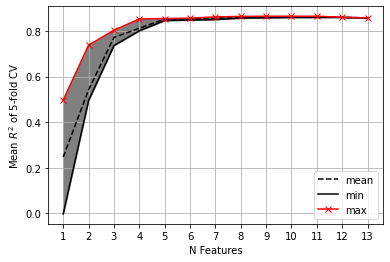

In [47]:
best_features_sr = seq_feature_importance(selected_features_sr, train_feat_df_unscaled)
best_features_sr

In [48]:
# All selected features with sr distance and back azimuth
selected_feat_sr_cv = svr_cv(train_feat_df_unscaled[selected_features_sr], train_y, folds)
print(selected_feat_sr_cv)
print(np.mean(selected_feat_sr_cv))

[0.84880884 0.8696219  0.84652445 0.85673114 0.86376006]
0.8570892801438973


In [49]:
# Top 4 selected features with sr distance and back azimuth
top_feat_sr_cv = svr_cv(train_feat_df_unscaled[best_features_sr[0:4]], train_y, folds)
print(top_feat_sr_cv )
print(np.mean(top_feat_sr_cv))

[0.85462108 0.85973951 0.83164372 0.85854228 0.85774593]
0.8524585048742391


iteration 0
[]
amp_02.0 0.4966748652140286
signal_max_amplitude 0.332138022807809
signal_variance 0.36722909917133123
noise_variance 0.04426192472254564
source_receiver_distance_logkm 0.07003698751961576
noise_max_amplitude 0.044501184759051335
receiver_back_azimuth 0.08457024057962974
source_depth_km -0.002566205699170765
iteration 1
['amp_02.0']
signal_max_amplitude 0.5150538512435698
signal_variance 0.5223037288352067
noise_variance 0.4971122940902563
source_receiver_distance_logkm 0.7375114910456636
noise_max_amplitude 0.4948287850873315
receiver_back_azimuth 0.594571949957029
source_depth_km 0.5490546863668462
iteration 2
['amp_02.0', 'source_receiver_distance_logkm']
signal_max_amplitude 0.7884936776493937
signal_variance 0.8014919137279823
noise_variance 0.7358275713226449
noise_max_amplitude 0.7358873556858054
receiver_back_azimuth 0.7739395083844489
source_depth_km 0.7367127855465443
iteration 3
['amp_02.0', 'source_receiver_distance_logkm', 'signal_variance']
signal_max_ampli

['amp_02.0',
 'source_receiver_distance_logkm',
 'signal_variance',
 'receiver_back_azimuth',
 'signal_max_amplitude',
 'source_depth_km',
 'noise_variance',
 'noise_max_amplitude']

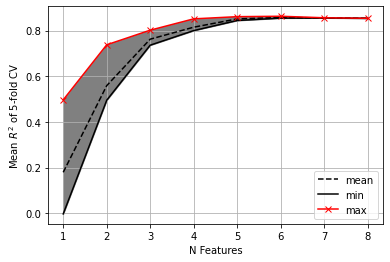

In [50]:
best_fewer_features_sr = seq_feature_importance(fewer_features_sr, train_feat_df_unscaled)
best_fewer_features_sr

In [51]:
# All fewer features
fewer_feat_sr_cv = svr_cv(train_feat_df_unscaled[fewer_features_sr], train_y, folds)
print(fewer_feat_sr_cv)
print(np.mean(fewer_feat_sr_cv))

[0.84587297 0.86067455 0.8421898  0.85919517 0.85955684]
0.8534978671311426


In [52]:
# Top 4 fewer features
top_fewer_feat_sr_cv = svr_cv(train_feat_df_unscaled[best_fewer_features_sr[0:4]], train_y, folds)
print(top_fewer_feat_sr_cv)
print(np.mean(top_fewer_feat_sr_cv))

[0.85440554 0.85947942 0.83253107 0.85376673 0.8549803 ]
0.8510326129645559


In [53]:
selected_feat_df = train_feat_df.copy()[selected_features_sr]
selected_feat_df.loc[:, "magnitude"] = train_y
corr = selected_feat_df.corr()
corr.style.background_gradient(cmap="coolwarm")

,amp_02.0,amp_04.0,amp_07.0,amp_10.0,amp_ratio_01.0,signal_dominant_amplitude,signal_variance,noise_variance,source_receiver_distance_logkm,noise_max_amplitude,signal_max_amplitude,receiver_back_azimuth,source_depth_km,magnitude
amp_02.0,1.000000,0.923048,0.894793,0.844938,0.591570,0.860594,0.872784,0.295693,-0.403244,0.298226,0.853427,-0.272875,-0.173919,0.708668
amp_04.0,0.923048,1.000000,0.961543,0.928430,0.498298,0.931370,0.946854,0.308323,-0.477374,0.311337,0.932316,-0.196581,-0.132744,0.679762
amp_07.0,0.894793,0.961543,1.000000,0.973858,0.466972,0.959797,0.976189,0.289171,-0.560238,0.295110,0.965927,-0.173613,-0.140253,0.619951
amp_10.0,0.844938,0.928430,0.973858,1.000000,0.414762,0.961808,0.983076,0.281426,-0.555358,0.286626,0.974227,-0.091080,-0.092913,0.591902
amp_ratio_01.0,0.591570,0.498298,0.466972,0.414762,1.000000,0.436935,0.443622,-0.150531,-0.144718,-0.117124,0.425969,-0.189199,-0.148294,0.471477
signal_dominant_amplitude,0.860594,0.931370,0.959797,0.961808,0.436935,1.000000,0.988832,0.289180,-0.558212,0.293675,0.993144,-0.147438,-0.126442,0.606174
signal_variance,0.872784,0.946854,0.976189,0.983076,0.443622,0.988832,1.000000,0.286239,-0.566081,0.291090,0.993615,-0.131032,-0.117181,0.613380
noise_variance,0.295693,0.308323,0.289171,0.281426,-0.150531,0.289180,0.286239,1.000000,-0.119860,0.983580,0.276818,-0.048839,-0.080358,0.248215
source_receiver_distance_logkm,-0.403244,-0.477374,-0.560238,-0.555358,-0.144718,-0.558212,-0.566081,-0.119860,1.000000,-0.135590,-0.577951,0.225469,0.391393,0.110064
noise_max_amplitude,0.298226,0.311337,0.295110,0.286626,-0.117124,0.293675,0.291090,0.983580,-0.135590,1.000000,0.281683,-0.048614,-0.091275,0.241578


## Add required starting features

['source_receiver_distance_logkm', 'receiver_back_azimuth', 'source_depth_km'] 0.17700153482554343
iteration 0
['source_receiver_distance_logkm', 'receiver_back_azimuth', 'source_depth_km']
amp_02.0 0.7805801335820661
amp_04.0 0.8012968034024102
amp_07.0 0.826617231646668
amp_10.0 0.8348437313121775
amp_ratio_01.0 0.3802024756822916
signal_max_amplitude 0.8062398676771869
signal_variance 0.8411932490895406
noise_variance 0.2198410058201584
noise_max_amplitude 0.2185219061710228
iteration 1
['source_receiver_distance_logkm', 'receiver_back_azimuth', 'source_depth_km', 'signal_variance']
amp_02.0 0.8541999625605813
amp_04.0 0.8449775399117844
amp_07.0 0.8441302697327304
amp_10.0 0.8430868044738198
amp_ratio_01.0 0.841939435656402
signal_max_amplitude 0.8524155088533334
noise_variance 0.8324385606216742
noise_max_amplitude 0.8313117137233554
iteration 2
['source_receiver_distance_logkm', 'receiver_back_azimuth', 'source_depth_km', 'signal_variance', 'amp_02.0']
amp_04.0 0.8532935362919541

['source_receiver_distance_logkm',
 'receiver_back_azimuth',
 'source_depth_km',
 'signal_variance',
 'amp_02.0',
 'signal_max_amplitude',
 'amp_ratio_01.0',
 'amp_10.0',
 'amp_04.0',
 'amp_07.0',
 'noise_variance',
 'noise_max_amplitude']

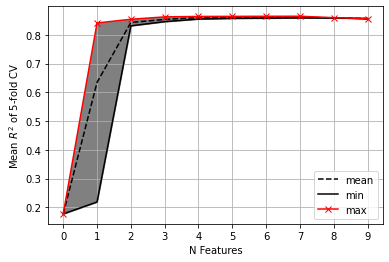

In [54]:
additional_features_sr = ['amp_02.0', 'amp_04.0', 'amp_07.0', 'amp_10.0', 'amp_ratio_01.0',
                       'signal_max_amplitude', 'signal_variance', 'noise_variance', 'noise_max_amplitude']
starting_features = ['source_receiver_distance_logkm','receiver_back_azimuth', 'source_depth_km']
best_features_with_start = seq_feature_importance(additional_features_sr, train_feat_df_unscaled,
                                                  starting_features=starting_features)
best_features_with_start

In [55]:
np.mean(svr_cv(train_feat_df_unscaled[best_features_with_start[0:4]], train_y, folds))

0.8411932490895406

In [56]:
np.mean(svr_cv(train_feat_df_unscaled[best_features_with_start[0:5]], train_y, folds))

0.8541999625605813

## Require starting features - linear model

['source_receiver_distance_logkm', 'sin_receiver_back_azimuth', 'source_depth_km'] 0.08232544022714976
iteration 0
['source_receiver_distance_logkm', 'sin_receiver_back_azimuth', 'source_depth_km']
amp_02.0 0.6893787907509756
amp_04.0 0.7183293587165942
amp_07.0 0.7159840504888761
amp_10.0 0.7047237263094639
amp_ratio_01.0 0.2933675895084196
signal_max_amplitude 0.6898270848267715
signal_dominant_frequency 0.09702513737298538
signal_variance 0.7317689984534244
noise_variance 0.14813513363934463
noise_max_amplitude 0.14790758329957734
signal_max_amplitude 0.6898270848267715
iteration 1
['source_receiver_distance_logkm', 'sin_receiver_back_azimuth', 'source_depth_km', 'signal_variance']
amp_02.0 0.7533275296237335
amp_04.0 0.744734664525763
amp_07.0 0.7353201768475375
amp_10.0 0.7315493760796373
amp_ratio_01.0 0.7402171840342487
signal_max_amplitude 0.7517485176274725
signal_dominant_frequency 0.7456443160735311
noise_variance 0.732237356643933
noise_max_amplitude 0.7323493970424576
sign

['source_receiver_distance_logkm',
 'sin_receiver_back_azimuth',
 'source_depth_km',
 'signal_variance',
 'amp_02.0',
 'signal_max_amplitude',
 'signal_dominant_frequency',
 'amp_ratio_01.0',
 'noise_variance',
 'amp_04.0',
 'signal_max_amplitude',
 'noise_max_amplitude',
 'amp_10.0',
 'amp_07.0']

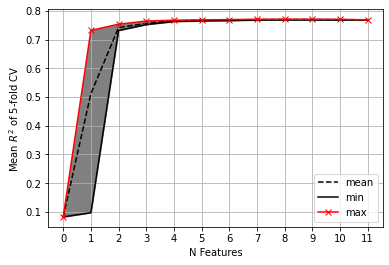

In [57]:
additional_features_sr = ['amp_02.0', 'amp_04.0', 'amp_07.0', 'amp_10.0', 'amp_ratio_01.0',
                       'signal_max_amplitude', 'signal_dominant_frequency', 'signal_variance', 
                          'noise_variance', 'noise_max_amplitude', 'signal_max_amplitude']
starting_features = ['source_receiver_distance_logkm','sin_receiver_back_azimuth', 'source_depth_km']
best_features_with_start_linear = seq_feature_importance(additional_features_sr, train_feat_df_unscaled,
                                                  starting_features=starting_features, kernel="linear")
best_features_with_start_linear

In [58]:
np.mean(svr_cv(train_feat_df_unscaled[best_features_with_start_linear[0:4]], train_y, folds, kernel='linear'))

0.7317689984534244

In [59]:
np.mean(svr_cv(train_feat_df_unscaled[best_features_with_start_linear[0:6]], train_y, folds, kernel="linear"))

0.7644043448495609

In [60]:
linear_features = ['source_receiver_distance_logkm',
 'sin_receiver_back_azimuth',
 'source_depth_km',
 'amp_02.0',
 'noise_max_amplitude',
 'signal_max_amplitude',
 'signal_variance',
 'noise_variance', 
 'amp_ratio_01.0']

np.mean(svr_cv(train_feat_df_unscaled[linear_features], train_y, folds, kernel='linear'))

0.7671930560099284

In [61]:
rbf_linear_features = ['source_receiver_distance_logkm',
 'receiver_back_azimuth',
 'source_depth_km',
 'amp_02.0',
 'noise_max_amplitude',
 'signal_max_amplitude',
 'signal_variance',
 'noise_variance', 
 'amp_ratio_01.0']

np.mean(svr_cv(train_feat_df_unscaled[rbf_linear_features], train_y, folds))

0.8551299473410321

In [62]:
linear_feat_df = train_feat_df.copy()[linear_features]
linear_feat_df.loc[:, "magnitude"] = train_y
corr = linear_feat_df.corr()
corr.style.background_gradient(cmap="coolwarm")

,source_receiver_distance_logkm,sin_receiver_back_azimuth,source_depth_km,amp_02.0,noise_max_amplitude,signal_max_amplitude,signal_variance,noise_variance,amp_ratio_01.0,magnitude
source_receiver_distance_logkm,1.000000,-0.220186,0.391393,-0.403244,-0.135590,-0.577951,-0.566081,-0.119860,-0.144718,0.110064
sin_receiver_back_azimuth,-0.220186,1.000000,-0.415507,0.302260,0.049076,0.138723,0.139049,0.051553,0.227191,0.227800
source_depth_km,0.391393,-0.415507,1.000000,-0.173919,-0.091275,-0.118055,-0.117181,-0.080358,-0.148294,0.055565
amp_02.0,-0.403244,0.302260,-0.173919,1.000000,0.298226,0.853427,0.872784,0.295693,0.591570,0.708668
noise_max_amplitude,-0.135590,0.049076,-0.091275,0.298226,1.000000,0.281683,0.291090,0.983580,-0.117124,0.241578
signal_max_amplitude,-0.577951,0.138723,-0.118055,0.853427,0.281683,1.000000,0.993615,0.276818,0.425969,0.583234
signal_variance,-0.566081,0.139049,-0.117181,0.872784,0.291090,0.993615,1.000000,0.286239,0.443622,0.613380
noise_variance,-0.119860,0.051553,-0.080358,0.295693,0.983580,0.276818,0.286239,1.000000,-0.150531,0.248215
amp_ratio_01.0,-0.144718,0.227191,-0.148294,0.591570,-0.117124,0.425969,0.443622,-0.150531,1.000000,0.471477
magnitude,0.110064,0.227800,0.055565,0.708668,0.241578,0.583234,0.613380,0.248215,0.471477,1.000000


In [63]:
test_feat_matrix_unscaled = compute_feature_matrix(test_df, scaler=False)
test_feat_matrix_scaled = scaler.transform(test_feat_matrix_unscaled)
test_feat_df_scaled = pd.DataFrame(test_feat_matrix_scaled, columns=columns)
test_y = test_df.magnitude.values

test_feat_df_scaled.head()

,amp_ratio_01.0,amp_ratio_02.0,amp_ratio_03.0,amp_ratio_04.0,amp_ratio_05.0,amp_ratio_06.0,amp_ratio_07.0,amp_ratio_08.0,amp_ratio_09.0,amp_ratio_10.0,...,signal_dominant_frequency,signal_dominant_amplitude,noise_max_amplitude,signal_max_amplitude,signal_variance,noise_variance,source_receiver_distance_logkm,source_depth_km,sin_receiver_back_azimuth,receiver_back_azimuth
0,0.923773,0.414739,-0.258803,0.061909,-0.645948,-1.111266,-1.121391,-1.053614,-0.865874,-0.686621,...,-2.830302,0.123895,1.624685,-0.184006,0.014271,1.656410,1.505119,2.024576,-0.064111,-0.328682
1,1.694057,0.731226,2.211133,0.953727,0.318628,0.676240,0.930610,0.562689,0.194007,-0.011554,...,-4.033080,0.828375,1.137779,0.702322,0.744761,1.044127,1.549250,0.664173,-0.095127,-0.308551
2,0.715487,0.473657,1.000694,0.913815,1.261583,1.460825,1.417582,1.261047,1.053524,1.029107,...,0.127848,0.469022,-1.320993,0.407623,0.399621,-1.220807,-1.072998,-0.815825,1.149883,-0.983455
3,-1.317196,0.027322,-0.726780,-1.156982,-1.444022,-1.453281,-1.405015,-1.376177,-1.448629,-1.546352,...,-2.830302,-1.540858,-0.465718,-1.540058,-1.641718,-0.496121,0.564782,-0.804613,2.450535,-1.885458
4,-1.545198,-1.824317,-1.228810,-0.737198,-0.837252,-0.916273,-0.874777,-0.870049,-0.905482,-0.881023,...,-0.037538,-0.714788,0.576772,-0.738742,-0.908644,0.605595,0.917563,0.888416,-0.683773,0.457205


In [64]:
svr_linear = SVR(C=1.0, epsilon=0.1, kernel="linear")
svr_linear.fit(train_feat_df[linear_features], train_y)

y_est_linear = svr_linear.predict(test_feat_df_scaled[linear_features])
linear_test_r2 =r2_score(test_y, y_est_linear) 
print(linear_test_r2)
train_est_linear = svr_linear.predict(train_feat_df[linear_features]) 
print(r2_score(train_y, train_est_linear))

0.7439858211569916
0.7670066690402719


In [65]:
svr_rbf = SVR(C=1.0, epsilon=0.1, kernel="rbf")
svr_rbf.fit(train_feat_df[rbf_linear_features], train_y)

y_est_rbf = svr_rbf.predict(test_feat_df_scaled[rbf_linear_features])
rbf_test_r2 = r2_score(test_y, y_est_rbf)
print(rbf_test_r2)
train_est_rbf = svr_rbf.predict(train_feat_df[rbf_linear_features]) 
print(r2_score(train_y, train_est_rbf))

0.8753087653911631
0.8968920576883755


Text(0.5, 1.05, 'P Magnitudes - SVR Linear')

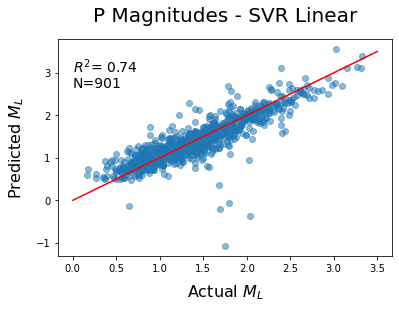

In [66]:
plt.scatter(test_y, y_est_linear, alpha=0.5)
plt.plot(np.arange(0, 4.0, 0.5), np.arange(0, 4.0, 0.5), color="red")
plt.xlabel(r"Actual $M_L$", fontsize=16, labelpad=10)
plt.ylabel(r"Predicted $M_L$", fontsize=16, labelpad=10)
plt.text(0, 3.0, f'{r"$R^2$="} {linear_test_r2:.02f}', fontsize=14)
plt.text(0, 2.65, f'N={test_feat_df_scaled.shape[0]}', fontsize=14)
plt.title("P Magnitudes - SVR Linear", fontsize=20, y=1.05)

Text(0.5, 1.05, '$M_L$ using P-arrival features')

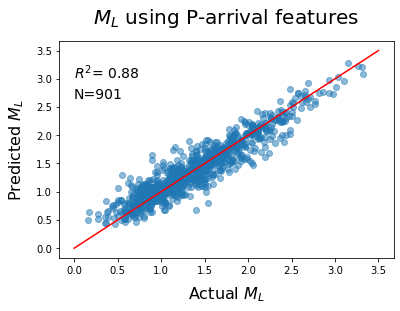

In [67]:
plt.scatter(test_y, y_est_rbf, alpha=0.5)
plt.plot(np.arange(0, 4.0, 0.5), np.arange(0, 4.0, 0.5), color="red")
plt.xlabel(r"Actual $M_L$", fontsize=16, labelpad=10)
plt.ylabel(r"Predicted $M_L$", fontsize=16, labelpad=10)
plt.text(0, 3.0, f'{r"$R^2$="} {rbf_test_r2:.02f}', fontsize=14)
plt.text(0, 2.65, f'N={test_feat_df_scaled.shape[0]}', fontsize=14)
plt.title(r"$M_L$ using P-arrival features", fontsize=20, y=1.05)

In [68]:
train_feat_df.shape

(3604, 46)

In [69]:
test_feat_df_scaled.shape

(901, 46)

In [70]:
svr_rbf = SVR(C=1.0, epsilon=0.1, kernel="rbf")
svr_rbf.fit(train_feat_df[train_feat_df.columns[no_sin_ba_feat_inds].tolist()], train_y)

y_est_rbf = svr_rbf.predict(test_feat_df_scaled[train_feat_df.columns[no_sin_ba_feat_inds].tolist()])
rbf_test_r2 = r2_score(test_y, y_est_rbf)
print(rbf_test_r2)
train_est_rbf = svr_rbf.predict(train_feat_df[train_feat_df.columns[no_sin_ba_feat_inds].tolist()]) 
print(r2_score(train_y, train_est_rbf))

0.8745432291290626
0.8955560916224129


## Closer look at features with sr features

In [ ]:
def add_feat_to_base(base_features, additional_features, all_features_cv=None, top_features_cv=None):

    cv_means = []

    for cf in additional_features:
        feat_list = base_features.copy()
        feat_list.append(cf)
        cv_vals = svr_cv(train_feat_df_unscaled[feat_list], train_y, folds)
        cv_means.append(np.mean(cv_vals))

    plt.scatter(range(len(additional_features)), cv_means, marker="x")
    plt.xticks(range(len(additional_features)), labels=additional_features, rotation=45);
    if all_features_cv is not None:
        plt.axhline(np.mean(all_features_cv))
    if top_features_cv is not None:
        plt.axhline(np.mean(top_features_cv), color="C1")
    plt.show()
    
    return cv_means

In [ ]:
base_features = ['source_receiver_distance_logkm','source_depth_km', "receiver_back_azimuth"]

correlated_features = ['amp_02.0', 'amp_10.0', 
                     'noise_max_amplitude',
                     'amp_04.0',
                     'amp_07.0',
                     'noise_variance',
                     'signal_variance',
                     'signal_dominant_amplitude']

cv_means = add_feat_to_base(base_features, correlated_features, all_features_cv=selected_feat_sr_cv, 
                           top_features_cv=top_feat_sr_cv)

base_features = ['source_receiver_distance_logkm','source_depth_km', "receiver_back_azimuth", 'amp_02.0']

correlated_features = ['amp_10.0',
                     'noise_max_amplitude',
                     'amp_04.0',
                     'amp_07.0',
                     'noise_variance',
                     'signal_variance',
                     'signal_dominant_amplitude']

cv_means_amp02  = add_feat_to_base(base_features, correlated_features, all_features_cv=selected_feat_sr_cv, 
                           top_features_cv=top_feat_sr_cv)

base_features = ['source_receiver_distance_logkm', "receiver_back_azimuth", 'amp_02.0']

correlated_features = ['amp_10.0',
                     'noise_max_amplitude',
                     'amp_04.0',
                     'amp_07.0',
                     'noise_variance',
                     'signal_variance',
                     'signal_dominant_amplitude']

cv_means_nodepth = add_feat_to_base(base_features, correlated_features, all_features_cv=selected_feat_sr_cv, 
                           top_features_cv=top_feat_sr_cv)

base_features = ['source_receiver_distance_logkm', 'amp_02.0']

correlated_features = ['amp_10.0',
                     'noise_max_amplitude',
                     'amp_04.0',
                     'amp_07.0',
                     'noise_variance',
                     'signal_variance',
                     'signal_dominant_amplitude']


cv_means_nodepth_noba = add_feat_to_base(base_features, correlated_features, all_features_cv=selected_feat_sr_cv, 
                           top_features_cv=top_feat_sr_cv)

# SR distance is important 
# base_features = ["receiver_back_azimuth",'amp_ratio_01.0', "amp_01.0"]

# correlated_features = ['amp_02.0', "amp_08.0", "amp_12.0", "amp_18.0", "signal_variance", 
#                        "signal_dominant_amplitude", "signal_max_amplitude"]

# cv_means_nodepth_nosrd = add_feat_to_base(base_features, correlated_features, all_features_cv=selected_feat_sr_cv, 
#                            top_features_cv=top_feat_sr_cv)

In [ ]:
base_features = ['source_receiver_distance_logkm','source_depth_km', "receiver_back_azimuth"]

correlated_features = ['signal_variance', 'amp_02.0', 'amp_10.0', 
                     'noise_max_amplitude',
                     'amp_04.0',
                     'amp_07.0',
                     'noise_variance',
                     'signal_dominant_amplitude']

cv_means = add_feat_to_base(base_features, correlated_features, all_features_cv=selected_feat_sr_cv, 
                           top_features_cv=top_feat_sr_cv)

base_features = ['source_receiver_distance_logkm','source_depth_km', "receiver_back_azimuth", 'signal_variance']

correlated_features = ['amp_02.0', 'amp_10.0', 
                     'noise_max_amplitude',
                     'amp_04.0',
                     'amp_07.0',
                     'noise_variance',
                     'signal_dominant_amplitude']

cv_means_amp02  = add_feat_to_base(base_features, correlated_features, all_features_cv=selected_feat_sr_cv, 
                           top_features_cv=top_feat_sr_cv)

base_features = ['source_receiver_distance_logkm', "receiver_back_azimuth", 'signal_variance']

correlated_features = ['amp_02.0', 'amp_10.0', 
                     'noise_max_amplitude',
                     'amp_04.0',
                     'amp_07.0',
                     'noise_variance',
                     'signal_dominant_amplitude']


cv_means_nodepth = add_feat_to_base(base_features, correlated_features, all_features_cv=selected_feat_sr_cv, 
                           top_features_cv=top_feat_sr_cv)

base_features = ['source_receiver_distance_logkm', 'signal_variance']

correlated_features = ['amp_02.0', 'amp_10.0', 
                     'noise_max_amplitude',
                     'amp_04.0',
                     'amp_07.0',
                     'noise_variance',
                     'signal_dominant_amplitude']

cv_means_nodepth_noba = add_feat_to_base(base_features, correlated_features, all_features_cv=selected_feat_sr_cv, 
                           top_features_cv=top_feat_sr_cv)

# SR distance is important 
# base_features = ["receiver_back_azimuth",'amp_ratio_01.0', "amp_01.0"]

# correlated_features = ['amp_02.0', "amp_08.0", "amp_12.0", "amp_18.0", "signal_variance", 
#                        "signal_dominant_amplitude", "signal_max_amplitude"]

# cv_means_nodepth_nosrd = add_feat_to_base(base_features, correlated_features, all_features_cv=selected_feat_sr_cv, 
#                            top_features_cv=top_feat_sr_cv)

In [ ]:
correlated_features = ['amp_02.0', 'amp_10.0',
                     'noise_max_amplitude',
                     'amp_04.0',
                     'amp_07.0',
                     'noise_variance',
                     'signal_variance',
                     'signal_dominant_amplitude']

plt.scatter( range(0,len(correlated_features)), cv_means, marker="x", label="no_amp2.0")
plt.scatter( range(1,len(correlated_features)), cv_means_amp02, marker="o", label="yes_amp2.0")
plt.scatter( range(1,len(correlated_features)), cv_means_nodepth, marker="v", label="yes_amp2.0_no_depth")
plt.scatter( range(1,len(correlated_features)), cv_means_nodepth_noba, marker="x", label="yes_amp2.0_nodepth_noba")
# plt.scatter( range(1,len(correlated_features)), cv_means_nodepth_nosrd, marker="x", label="yes_amp1.0_nodepth_nosr")

plt.xticks(range(len(correlated_features)), labels=correlated_features, rotation=45);
plt.axhline(np.mean(selected_feat_sr_cv), label="all_selected_features")
plt.axhline(np.mean(top_feat_sr_cv), color="C1", label="top 5 features")
plt.legend();

In [ ]:
correlated_features = ['signal_variance', 'amp_02.0', 'amp_10.0', 
                     'noise_max_amplitude',
                     'amp_04.0',
                     'amp_07.0',
                     'noise_variance',
                     'signal_dominant_amplitude']

plt.scatter( range(0,len(correlated_features)), cv_means, marker="x", label="no_sv")
plt.scatter( range(1,len(correlated_features)), cv_means_amp02, marker="o", label="yes_sv")
plt.scatter( range(1,len(correlated_features)), cv_means_nodepth, marker="v", label="yes_sv_no_depth")
plt.scatter( range(1,len(correlated_features)), cv_means_nodepth_noba, marker="x", label="yes_sv_nodepth_noba")
# plt.scatter( range(1,len(correlated_features)), cv_means_nodepth_nosrd, marker="x", label="yes_amp1.0_nodepth_nosr")

plt.xticks(range(len(correlated_features)), labels=correlated_features, rotation=45);
plt.axhline(np.mean(selected_feat_sr_cv), label="all_selected_features")
plt.axhline(np.mean(top_feat_sr_cv), color="C1", label="top 5 features")
plt.legend();

In [ ]:
fewer_features_sr = ['source_receiver_distance_logkm', "receiver_back_azimuth", "source_depth_km",'amp_02.0', 
                          "amp_10.0", "signal_variance"]
fewer_feat_sr_df = train_feat_df.copy()[fewer_features_sr]
fewer_feat_sr_df.loc[:, "magnitude"] = train_y
corr = fewer_feat_sr_df.corr()
corr.style.background_gradient(cmap="coolwarm")

In [ ]:
fewer_feat_sr_cv = svr_cv(train_feat_df_unscaled[fewer_features_sr], train_y, folds)
print(fewer_feat_sr_cv)
print(np.mean(fewer_feat_sr_cv))

In [ ]:
fewest_features_sr = ['source_receiver_distance_logkm', "receiver_back_azimuth", "source_depth_km","signal_variance"]
fewest_feat_sr_df = train_feat_df.copy()[fewest_features_sr]
fewest_feat_sr_df.loc[:, "magnitude"] = train_y
corr = fewest_feat_sr_df.corr()
corr.style.background_gradient(cmap="coolwarm")

In [ ]:
fewest_feat_sr_cv = svr_cv(train_feat_df_unscaled[fewest_features_sr], train_y, folds)
print(fewest_feat_sr_cv)
print(np.mean(fewest_feat_sr_cv))

In [ ]:
linear_features_sr = ['source_receiver_distance_logkm', "sin_receiver_back_azimuth", "source_depth_km",
                      "signal_variance"]
                      #,'amp_02.0', "amp_10.0", "noise_variance"]

linear_feat_sr_cv = svr_cv(train_feat_df_unscaled[linear_features_sr], train_y, folds, kernel="linear")
print(linear_feat_sr_cv)
print(np.mean(linear_feat_sr_cv))

## Default C, gamma, and epsilon seem to work well for SVR with RBF

In [ ]:
#C_range = [1.0]#np.logspace(-2, 10, 5)
gamma_range = [7.4e-05, 0.1, 0.2, 0.3, 0.4, 5e-1, 1, "scale", "auto"]#np.logspace(-9, 3, 5)
epsilon_range = [5e-3, 1e-2, 5e-2, 1e-1, 2e-1]
param_grid = {"svr__gamma":gamma_range,  "svr__epsilon":epsilon_range} #"svr__C":C_range,
pipeline = Pipeline(steps=[("scaler", StandardScaler()), ('svr', SVR(C=1.0))])
grid = GridSearchCV(pipeline, param_grid=param_grid, scoring="r2", n_jobs=3, cv=folds)
svr_cv_results = grid.fit(train_feat_df_unscaled[fewer_features_sr], train_y)

In [ ]:
scores = grid.cv_results_["mean_test_score"].reshape(len(epsilon_range), len(gamma_range))
plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=0.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(
    scores,
    interpolation="nearest",
    cmap=plt.cm.viridis,
    #norm=MidpointNormalize(vmin=0.2, midpoint=0.92),
)
plt.xlabel("Gamma")
plt.ylabel("Epsilon")
plt.colorbar()
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.yticks(np.arange(len(epsilon_range)), epsilon_range)
plt.title("Validation accuracy")
plt.show()

## XGBoost

Try more hyperparameters, try with limited features

In [ ]:
from xgboost import XGBRegressor
from xgboost import DMatrix
import xgboost

In [ ]:
from sklearn.utils.fixes import loguniform
import scipy.stats as stats

In [ ]:
xgb = XGBRegressor(objective='reg:squarederror', eval_metric='rmse').fit(
                                    train_feat_matrix_unscaled[folds[0][0]], train_y[folds[0][0]])
xgb.score(train_feat_matrix_unscaled[folds[0][1]], train_y[folds[0][1]])

In [ ]:
train_feat_df.columns[43]

In [ ]:
fig, ax = plt.subplots(1, figsize=(10, 20))
xgboost.plot_importance(xgb, ax=ax)

In [ ]:
feat_bool = np.isin(train_feat_df.columns, fewer_features_sr)
xgb = XGBRegressor(objective='reg:squarederror', eval_metric='rmse').fit(
                                    train_feat_matrix_unscaled[folds[0][0]][:, feat_bool], train_y[folds[0][0]])
xgb.score(train_feat_matrix_unscaled[folds[0][1]][:, feat_bool], train_y[folds[0][1]])

In [ ]:
xgboost.plot_importance(xgb)

In [ ]:
feat_bool = np.isin(train_feat_df.columns, fewer_features_lat_lon)
xgb = XGBRegressor(objective='reg:squarederror', eval_metric='rmse').fit(
                                    train_feat_matrix_unscaled[folds[0][0]][:, feat_bool], train_y[folds[0][0]])
xgb.score(train_feat_matrix_unscaled[folds[0][1]][:, feat_bool], train_y[folds[0][1]])

In [ ]:
xgboost.plot_importance(xgb)

In [ ]:
grid_params = {'max_depth': [1, 2, 3, 5, 10], 
          'eta': [0.05, 0.1, 0.2, 0.3, 0.5],
          'gamma': [0, 0.2, 0.5, 1, 1.5, 2, 5], 
         'min_child_weight':[0, 0.5, 1, 2], 
         'max_delta_step': [0, 1, 2], 
          'subsample': [0.5, 1]}

params = {'max_depth': stats.randint(3, 18),
          'gamma': stats.uniform(0, 5),
          'learning_rate': loguniform(1e-2, 1e0),
          'subsample': np.arange(0.5, 1.0, 0.1),
          'colsample_bytree':stats.uniform(0.5,1),
          'min_child_weight':stats.randint(0, 10), 
          'n_estimators': [100, 250, 500, 750],
          }
    
# params = {'objective': 'reg:squarederror'}
# params['eval_metric'] = 'rmse'
# params['nthread'] = 2

In [ ]:
xgb = XGBRegressor(objective='reg:squarederror', eval_metric='rmse') #, topnthread=2
# grid_search = GridSearchCV(xgb, param_grid=grid_params, scoring="r2", 
#                            n_jobs=3, cv=folds).fit(train_feat_matrix_unscaled, train_y)
rand_search = RandomizedSearchCV(xgb, param_distributions=params, scoring="r2", 
                           n_jobs=3, cv=folds).fit(train_feat_matrix_unscaled[:, feat_bool], train_y)

In [ ]:
rand_search.best_estimator_

In [ ]:
# {'eta': 0.1,
#  'gamma': 0.5,
#  'max_delta_step': 1,
#  'max_depth': 5,
#  'min_child_weight': 0.5}

# 0.8620877350386309

In [ ]:
rand_search.best_params_

In [ ]:
rand_search.best_score_

In [ ]:
results_df = pd.DataFrame(grid_search.cv_results_)
results_df.sort_values("rank_test_score")

In [ ]:
num_round = 100
dtrain = DMatrix(train_feat_matrix_unscaled, label=train_y, feature_names=train_feat_df_unscaled.columns)
bst_cv = xgboost.cv(param, dtrain, num_round, folds=folds, early_stopping_rounds=3, 
               callbacks=[xgb.callback.EvaluationMonitor(show_stdv=True)])

In [ ]:
x_ticks = range(1, len(bst_cv)+1)
plt.plot(x_ticks, bst_cv["train-rmse-mean"], color="k")
plt.plot(x_ticks, bst_cv["train-rmse-mean"]+bst_cv["train-rmse-std"], linestyle="--", color="C0")
plt.plot(x_ticks, bst_cv["train-rmse-mean"]-bst_cv["train-rmse-std"], linestyle="--", color="C0")
plt.fill_between(x_ticks,bst_cv["train-rmse-mean"]+bst_cv["train-rmse-std"], 
                 bst_cv["train-rmse-mean"]-bst_cv["train-rmse-std"], color="C0", alpha=0.5, label="train")

plt.plot(x_ticks, bst_cv["test-rmse-mean"], color="k")
plt.plot(x_ticks, bst_cv["test-rmse-mean"]+bst_cv["test-rmse-std"], linestyle="--", color="C1")
plt.plot(x_ticks, bst_cv["test-rmse-mean"]-bst_cv["test-rmse-std"], linestyle="--", color="C1")
plt.fill_between(x_ticks, bst_cv["test-rmse-mean"]+bst_cv["test-rmse-std"], 
                 bst_cv["test-rmse-mean"]-bst_cv["test-rmse-std"], color="C1", alpha=0.5, label="test")

plt.ylabel("RMSE")
plt.xlabel("Iteration")

#plt.xticks(x_ticks)
plt.legend()